In [31]:
from sklearn.mixture import GaussianMixture
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [32]:
from clustering.utils import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
#%cd ..

/content/drive/My Drive/GitHub/master-thesis


# Import Data

In [33]:
df, answers, info_dict = get_cluster_input_data()

In [39]:
df.head()

,gender,postnr,region,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,...,Q14_ocupation_employee_private,Q14_ocupation_unemployed,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum
0,Man,2830,Capital,4.796778,5.0,7.0,4.0,7.0,4.0,5.0,...,0,0,1,0,0,0,2.0,4.0,4.0,2.0
1,Woman,4654,Zealand,7.000000,7.0,7.0,5.0,7.0,6.0,5.0,...,0,0,1,0,0,0,2.0,4.0,2.0,4.0
2,Woman,7451,Central,7.000000,7.0,7.0,7.0,7.0,4.0,3.0,...,0,0,1,0,0,0,NaN,NaN,NaN,NaN
3,Man,4700,Zealand,6.000000,1.0,7.0,2.0,1.0,7.0,4.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,Man,4000,Zealand,5.000000,1.0,1.0,2.0,1.0,2.0,2.0,...,0,0,0,0,0,1,2.0,4.0,NaN,NaN


In [40]:
info_dict

{'cluster_input_cols': ['Q1_2_covid_is_threat',
  'Q2_1_easy_to_follow_advice',
  'Q2_2_can_follow_advice_if_wanted',
  'Q2_3_if_follow_advice_safe',
  'Q2_4_if_follow_advice_others_safe',
  'Q2_5_follow_advice_relationships_impared',
  'Q2_6_follow_advice_life_degraded',
  'Q3_1_aware_hand_hygiene',
  'Q3_2_avoid_contact',
  'Q3_3_ensure_frequent_cleaning',
  'Q3_4_avoid_risk_groups',
  'Q3_5_keep_distance',
  'Q3_6_avoid_crowds',
  'Q3_7_minimize_activities_w_contact',
  'Q5_4_yourself_kept_distance',
  'Q5_5_feel_urge_scold',
  'Q6_2_advices_important',
  'Q6_3_others_can_avoid_spreading',
  'Q6_5_ownership_of_advice',
  'Q6_6_clear_information_on_advice_reason',
  'Q6_7_advice_limits_daily_activities',
  'Q6_9_trust_political_strategy',
  'Ny1_nr_times_wearing_masks_last_week'],
 'data_path': 'data/preprocessing/220216_preprocessed_data_missing_data.csv',
 'scaler_type': 'MinMaxScaler()'}

In [41]:
answers_sampled = pd.DataFrame(answers).sample(10000).to_numpy()

# GM clustering

## Elbow approach to determine ideal amount of clusters

In [42]:
# Set up a range of cluster numbers to try
n_range = range(2,15)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    cluster_labels = gm.predict(answers_sampled)
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(answers_sampled))
    aic_score.append(gm.aic(answers_sampled))

100%|██████████| 13/13 [03:15<00:00, 15.04s/it]


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

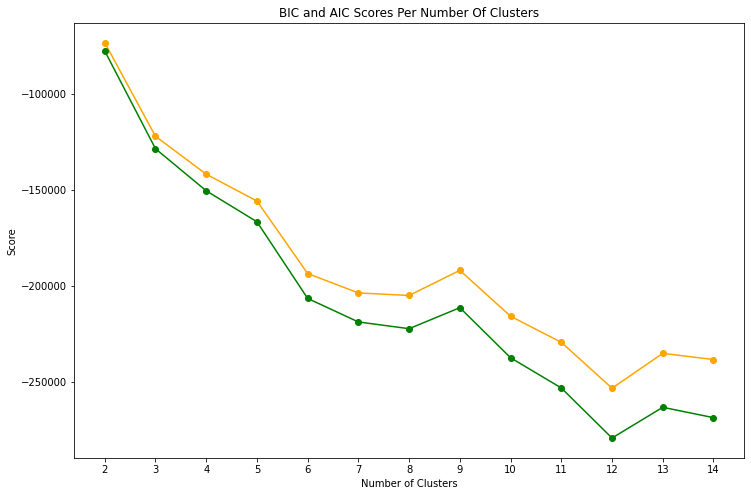

In [43]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

## Probabilistic Approach to determine number of clusters

In [44]:
from scipy.stats import norm
mean = 2
std = 3
prior_dist = norm(loc=mean, scale=std)

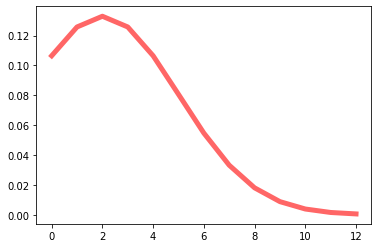

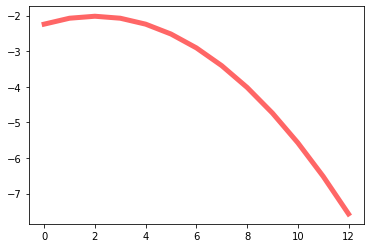

In [45]:
x = np.arange(13)
plt.plot(x, prior_dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()
plt.plot(x, prior_dist.logpdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

In [46]:
# Set up a range of cluster numbers to try
n_range = range(2,15)
list_log_prob_data_given_model = []
list_log_prob_model = []
list_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    # init & fit gmm
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    
    # Calculate Log Probabilities
    log_prob_data_given_model = gm.score(answers_sampled) # Computes the per-sample average log-likelihood of the given data X
    log_prob_model = prior_dist.logpdf(n)
    score = log_prob_data_given_model + log_prob_model

    # Append values to list
    list_log_prob_data_given_model.append(log_prob_data_given_model)
    list_log_prob_model.append(log_prob_model)
    list_score.append(score)



100%|██████████| 13/13 [03:32<00:00, 16.33s/it]


Text(0.5, 1.0, 'Probabilistic Evaluation')

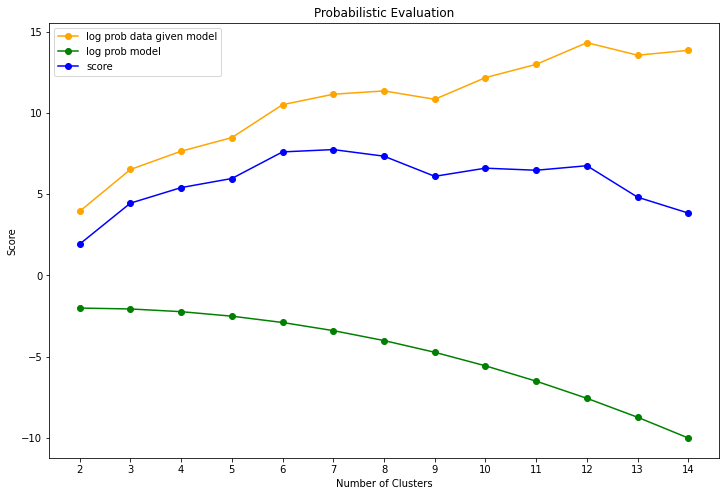

In [47]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, list_log_prob_data_given_model, '-o', color='orange', label='log prob data given model')
ax.plot(n_range, list_log_prob_model, '-o', color='green', label='log prob model')
ax.plot(n_range, list_score, '-o', color='blue', label='score')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.legend()
ax.set_title('Probabilistic Evaluation')

In [48]:
list_score

[1.9172104142268735,
 4.437822200338941,
 5.396267038109081,
 5.9558791653616465,
 7.593582698729317,
 7.7361379109335155,
 7.330239630784797,
 6.091111532089754,
 6.592363729373717,
 6.4643343129613475,
 6.7426478306313955,
 4.805618230606939,
 3.827468616117704]

In [49]:
n_clusters = n_range[np.argmax(list_score)]
n_clusters

7

## GM fit

In [50]:
n_clusters = 3
gm = GaussianMixture(n_components=n_clusters, 
                         random_state=123, 
                         n_init=6)
gm.fit(answers)

GaussianMixture(n_components=3, n_init=6, random_state=123)

In [51]:
df['group'] = gm.predict(answers)
df['group_prob'] = pd.DataFrame(gm.predict_proba(answers)).max(axis=1)
df.head()

,gender,postnr,region,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,...,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum,group,group_prob
0,Man,2830,Capital,4.796778,5.0,7.0,4.0,7.0,4.0,5.0,...,1,0,0,0,2.0,4.0,4.0,2.0,0,0.997792
1,Woman,4654,Zealand,7.000000,7.0,7.0,5.0,7.0,6.0,5.0,...,1,0,0,0,2.0,4.0,2.0,4.0,1,0.999983
2,Woman,7451,Central,7.000000,7.0,7.0,7.0,7.0,4.0,3.0,...,1,0,0,0,NaN,NaN,NaN,NaN,0,0.994414
3,Man,4700,Zealand,6.000000,1.0,7.0,2.0,1.0,7.0,4.0,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0.992695
4,Man,4000,Zealand,5.000000,1.0,1.0,2.0,1.0,2.0,2.0,...,0,0,0,1,2.0,4.0,NaN,NaN,2,1.000000


## Save for general clustering evaluation

In [52]:
df.to_csv('data/clustering/220323_gmm_clustered.csv', index=False)

# Specific Clustering Method Analysis

In [53]:
gm.weights_

array([0.28843901, 0.44322344, 0.26833755])

In [54]:
df['group'].value_counts(dropna=False)

1    54541
0    36294
2    31994
Name: group, dtype: int64

## Group Probability

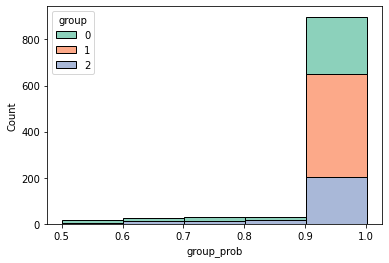

In [55]:
df_sample = df.sample(1000)
sns.histplot(data=df_sample, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
plt.show()

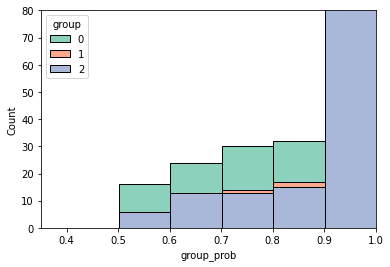

In [56]:
fig, ax = plt.subplots()
sns.histplot(data=df_sample, ax=ax, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
ax.set_xlim(0.35, 1)
ax.set_ylim(0,80)
plt.show()

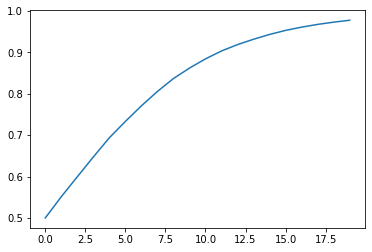

In [57]:
prob_list = []
for i in np.arange(0, 0.2, 0.01):
  prob = df['group_prob'].quantile(i)
  prob_list.append(prob)

plt.plot(prob_list)
plt.show()

## Filter and plot interesting columns - in evaluation file

In [58]:
df_questions = pd.DataFrame(gm.means_.T)
df_questions['behaviour_cols'] = behaviour_cols
df_questions['std'] = df_questions.std(axis=1)

df_questions.sort_values(by='std', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,behaviour_cols,std
10,0.785533,1.000000,0.623644,Q3_4_avoid_risk_groups,0.188789
13,0.679000,0.835704,0.490786,Q3_7_minimize_activities_w_contact,0.172699
12,0.725866,0.881285,0.545416,Q3_6_avoid_crowds,0.168090
11,0.742893,0.907550,0.575872,Q3_5_keep_distance,0.165840
8,0.740048,0.882957,0.553014,Q3_2_avoid_contact,0.165462
9,0.628282,0.833151,0.527801,Q3_3_ensure_frequent_cleaning,0.155621
21,0.724088,0.738218,0.505763,Q6_9_trust_political_strategy,0.130321
7,0.836209,1.000000,0.742952,Q3_1_aware_hand_hygiene,0.130127
14,0.783566,0.910930,0.657654,Q5_4_yourself_kept_distance,0.126638
3,0.807519,0.786567,0.584153,Q2_3_if_follow_advice_safe,0.123358


In [73]:
top_3_cols = df_questions.sort_values(by='std', ascending=False)['behaviour_cols'].iloc[:3].tolist() #.index[:3].tolist()
#for i in range(len(top_3_cols)):
#  top_3_cols[i] = str(top_3_cols[i])
top_3_cols

['Q3_4_avoid_risk_groups',
 'Q3_7_minimize_activities_w_contact',
 'Q3_6_avoid_crowds']

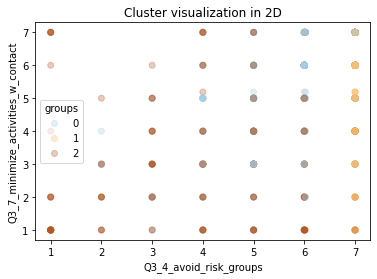

In [77]:
df_sample = df.sample(1000)
scatter = plt.(df_sample[top_3_cols[0]], df_sample[top_3_cols[1]], c=df_sample['group'], cmap='Paired', alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], title="groups", labels=[0,1,2,3,4,5,6])
plt.xlabel(top_3_cols[0])
plt.ylabel(top_3_cols[1])
plt.title('Cluster visualization in 2D')
plt.show()

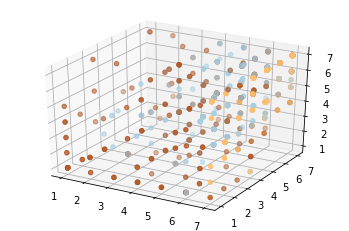

In [75]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_sample[top_3_cols[0]], df_sample[top_3_cols[1]], df_sample[top_3_cols[2]], c=df_sample['group'], cmap='Paired')